In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
train_folder = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\crop_dataset\crop_dataset"
test_folder = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\test_data\test_data"

train_class_folders = os.listdir(train_folder)

# Dictionary for naming the class types

classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

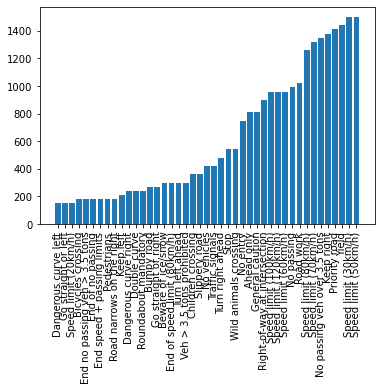

In [3]:
# Get number of instances per class and visualize the data

train_numberOfInstancesPerClass = []
class_names = []

for folder in train_class_folders:
    train_files = os.listdir(train_folder + '/' + folder)
    train_numberOfInstancesPerClass.append(len(train_files))
    class_names.append(classes[int(folder)])

pairs = zip(train_numberOfInstancesPerClass, class_names)
pairs = sorted(pairs)
tuples = zip(*pairs)
train_numberOfInstancesPerClass, class_names = [
    list(tuple) for tuple in tuples]

plt.bar(class_names, train_numberOfInstancesPerClass)
plt.xticks(class_names, rotation='vertical')
plt.show()

In [4]:
# Creating image data and label arrs for training/validation sets

images = []
labels = []

for imgClass in range(len(classes)):
    imgFolder_path = train_folder + "\\" + str(imgClass).zfill(5)
    #print(imgFolder_path)
    imgFolder = os.listdir(imgFolder_path)

    for img in imgFolder:
        image = plt.imread(imgFolder_path + "\\" + img)  # get an image
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))  # resize all images to same size
        images.append(np.array(image))
        labels.append(imgClass)

images = np.array(images)
labels = np.array(labels)

In [5]:
# Shuffle the dataset

shuffle_indexes = np.arange(images.shape[0])
np.random.shuffle(shuffle_indexes)
images = images[shuffle_indexes]
labels = labels[shuffle_indexes]

In [6]:
# Create the training and validation sets 

x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.3, shuffle=True)

x_train = x_train/255
x_val = x_val/255  # !!!! WHY?

# Convert classes to one-hot vectors
y_train = keras.utils.to_categorical(y_train, len(classes))
y_val = keras.utils.to_categorical(y_val, len(classes))

In [7]:
# Load the test data and create the test sets

test_csv = pd.read_csv(r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\test_labels.csv")
labels = test_csv['label'].values  # y_test
images = test_csv['image'].values
x_test = []

for imagePath in images:
    image = plt.imread(test_folder+ "\\" + imagePath)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((32, 32))
    x_test.append(np.array(image))

x_test = np.array(x_test)
x_test = x_test/255

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Önceden eğitilmiş ResNet50 modelini yükleme
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# ResNet modelinin katmanlarını dondurma
for layer in resnet_model.layers:
    layer.trainable = False

# Yeni bir Keras modeli oluşturma
model = Sequential()

# ResNet modelini ekleme
model.add(resnet_model)

# Flatten katmanı
model.add(Flatten())

# Tam bağlantılı katmanlar
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Çıkış katmanı
model.add(Dense(43, activation='softmax'))  # 43 sınıf için çıkış katmanı

# Modeli derleme
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 86s 134ms/step - accuracy: 0.0462 - loss: 3.6804 - val_accuracy: 0.0856 - val_loss: 3.4260
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 76s 131ms/step - accuracy: 0.0701 - loss: 3.4280 - val_accuracy: 0.1299 - val_loss: 3.2285
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.1006 - loss: 3.2650 - val_accuracy: 0.1508 - val_loss: 2.9904
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - accuracy: 0.1221 - loss: 3.1236 - val_accuracy: 0.1567 - val_loss: 2.8750
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 73s 125ms/step - accuracy: 0.1421 - loss: 3.0221 - val_accuracy: 0.1688 - val_loss: 2.8979
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.1522 - loss: 2.9800 - val_accuracy: 0.1909 - val_loss: 2.7881
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.1521 - loss: 2.9653 - val_accuracy: 0.1779 - val_loss: 2.8231
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.1508 - loss: 2

In [9]:
from keras.utils import to_categorical

labels_one_hot = to_categorical(labels)


In [10]:
# Modeli Değerlendirme
test_loss, test_acc = model.evaluate(x_test, labels_one_hot)
print('Test accuracy:', test_acc)

395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.1960 - loss: 2.8128
Test accuracy: 0.19714964926242828


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# ResNet50 modelini yükleme
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# ResNet50 modelinin çıkışına uygun olarak yeni bir çıkış katmanı oluşturma
flatten_layer = Flatten()(resnet_model.output)
dense_layer = Dense(512, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(43, activation='softmax')(dropout_layer)

# Yeni modeli oluşturma
model = Model(inputs=resnet_model.input, outputs=output_layer)

# Modeli derleme
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))



Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 457s 741ms/step - accuracy: 0.4640 - loss: 2.3076 - val_accuracy: 0.0978 - val_loss: 7.5116
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 428s 734ms/step - accuracy: 0.8102 - loss: 0.7235 - val_accuracy: 0.9222 - val_loss: 0.3961
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 429s 736ms/step - accuracy: 0.8883 - loss: 0.4619 - val_accuracy: 0.9114 - val_loss: 0.4641
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 430s 737ms/step - accuracy: 0.9314 - loss: 0.2743 - val_accuracy: 0.3604 - val_loss: 3.9097
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 429s 735ms/step - accuracy: 0.8555 - loss: 0.5664 - val_accuracy: 0.9598 - val_loss: 0.1218
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 429s 735ms/step - accuracy: 0.9533 - loss: 0.1871 - val_accuracy: 0.9732 - val_loss: 0.0835
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 428s 734ms/step - accuracy: 0.9728 - loss: 0.1099 - val_accuracy: 0.9765 - val_loss: 0.0842
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 456s 782ms/step - accuracy: 0.9734 -

In [12]:
# Modeli değerlendirme
test_loss, test_acc = model.evaluate(x_test, labels_one_hot)
print('Test accuracy:', test_acc)


395/395 ━━━━━━━━━━━━━━━━━━━━ 87s 221ms/step - accuracy: 0.9381 - loss: 0.2799
Test accuracy: 0.9354711174964905


In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 'vgg_model_unfreeze_2block' adlı eğitilmiş modelinizin yüklendiği varsayılıyor.
# Eğer bir dosyaya kaydedilmişse, yükleyebilirsiniz: model = load_model('sizin_modelinizin_yolu.h5')

# Adım 1: Olasılıkları tahmin edin ve sınıf etiketlerine dönüştürün
tahminler = model.predict(x_test)  # Olasılıkları tahmin edin
tahmin_edilen_sınıflar = np.argmax(tahminler, axis=1)  # Olasılıkları sınıf etiketlerine dönüştürün

# Adım 2: Gerekiyorsa one-hot kodlu etiketleri sınıf etiketlerine dönüştürün
gerçek_sınıflar = np.argmax(labels_one_hot, axis=1)  # One-hot kodlu etiketleri sınıf etiketlerine dönüştürün

# Adım 3: Metrikleri Hesapla
macro_precision = precision_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='macro')
macro_recall = recall_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='macro')
macro_f1_score = f1_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='macro')

micro_precision = precision_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='micro')
micro_recall = recall_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='micro')
micro_f1_score = f1_score(gerçek_sınıflar, tahmin_edilen_sınıflar, average='micro')

karışıklık_matrisi = confusion_matrix(gerçek_sınıflar, tahmin_edilen_sınıflar)

# Sonuçları Göster
print("Macro-Ortalama Kesinlik:", macro_precision)
print("Macro-Ortalama Duyarlılık:", macro_recall)
print("Macro-Ortalama F1 Skoru:", macro_f1_score)
print("\nMikro-Ortalama Kesinlik:", micro_precision)
print("Mikro-Ortalama Duyarlılık:", micro_recall)
print("Mikro-Ortalama F1 Skoru:", micro_f1_score)


395/395 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step
Macro-Ortalama Kesinlik: 0.914591454744066
Macro-Ortalama Duyarlılık: 0.9067896884787685
Macro-Ortalama F1 Skoru: 0.9032725295873981

Mikro-Ortalama Kesinlik: 0.935471100554236
Mikro-Ortalama Duyarlılık: 0.935471100554236
Mikro-Ortalama F1 Skoru: 0.935471100554236


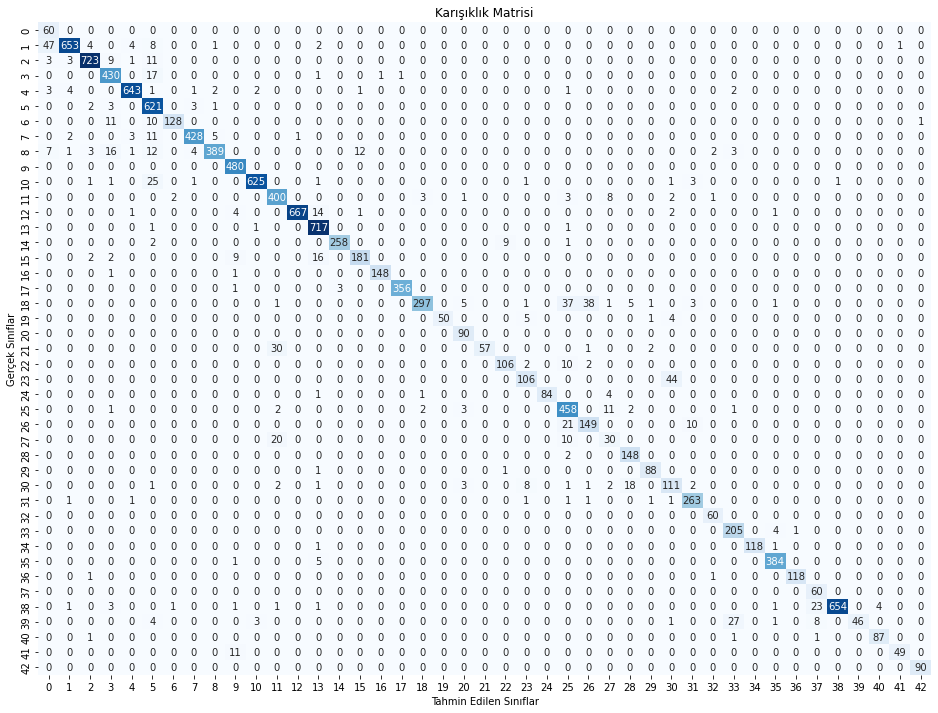

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(16, 12))
sns.heatmap(karışıklık_matrisi, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")
plt.show()
